# Kampff lab - Ultra dense survey


Here a description of the dataset:
http://www.kampff-lab.org/ultra-dense-survey/

Here the official publication of this open dataset:
https://crcns.org/data-sets/methods/hdr-1/about-hdr-1

And a paper is being preparing here:
https://doi.org/10.1101/275818


## Introduction

This dataset explore optimal size and density of electrodes.

Here 255 extracellular electrodes (5 x 5 μm and spacing of 1 μm) 

## Download

Dataset must downloaded locally and manually from crcns or from the google drive in **"workdir"** path.


## The PRB file
tridesclous need a PRB file that describe the geometry of probe.

Create it by copy/paste or download it via github.

In [1]:
# suposing the datset is downloaded here
workdir = '/media/samuel/dataspikesorting/DataSpikeSortingHD2/kampff/ultra dense/'
filename = workdir + 'T2/amplifier2017-02-08T21_38_55.bin'


In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import tridesclous as tdc
from tridesclous import DataIO, CatalogueConstructor, Peeler
import os, shutil

## create a DataIO (and remove if already exists)

In [4]:
dirname = workdir + 'tdc_amplifier2017-02-02T17_18_46'

if os.path.exists(dirname):
    #remove is already exists
    shutil.rmtree(dirname)
    
dataio = DataIO(dirname=dirname)

# feed DataIO with one file
dataio.set_data_source(type='RawData', filenames=[filename], 
                    sample_rate=20000., dtype='int16', total_channel=256,
                    bit_to_microVolt=0.195)
print(dataio)

# set the probe file
dataio.set_probe_file('kampff_ultra_dense_256.prb')

DataIO <id: 140663815591192> 
  workdir: /media/samuel/dataspikesorting/DataSpikeSortingHD2/kampff/ultra dense/tdc_amplifier2017-02-02T17_18_46
  sample_rate: 20000.0
  total_channel: 256
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch252 ch253 ch254 ch255]
  nb_segment: 1
  length: 32840000
  durations: 1642.0 s.


# CatalogueConstructor

Run all chain in one shot.

In [6]:
cc = CatalogueConstructor(dataio=dataio, chan_grp=0)

fullchain_kargs = {
    'duration' : 300.,
    'preprocessor' : {
        'highpass_freq' : 400.,
        'lowpass_freq' : 5000.,
        'smooth_size' : 0,
        'chunksize' : 1024,
        'lostfront_chunksize' : 128,
        'signalpreprocessor_engine' : 'numpy',
    },
    'peak_detector' : {
        'peakdetector_engine' : 'numpy',
        'peak_sign' : '-',
        'relative_threshold' : 5.,
        'peak_span' : 0.0002,
    },
    'noise_snippet' : {
        'nb_snippet' : 300,
    },
    'extract_waveforms' : {
        'n_left' : -20,
        'n_right' : 30,
        'mode' : 'rand',
        'nb_max' : 20000,
        'align_waveform' : False,
    },
    'clean_waveforms' : {
        'alien_value_threshold' : 100.,
    },
  }
feat_method = 'peak_max'
feat_kargs = {}
clust_method = 'sawchaincut'
clust_kargs = {}
       
tdc.apply_all_catalogue_steps(cc, fullchain_kargs, 
        feat_method, feat_kargs,clust_method, clust_kargs)
print(cc)

estimate_signals_noise 13.255640349001624
run_signalprocessor 330.4766073050014
extract_some_waveforms 28.491697482000745
clean_waveforms 24.889163197000016
extract_some_noise 0.9550839600015024
project 0.31667621100132237
order_clusters waveforms_rms
find_clusters 39.03489092699965
CatalogueConstructor
  chan_grp 0 - ch0 ch1 ch2 ... ch254 ch255
  nb_peak_by_segment: 43688
  some_waveforms.shape: (16037, 50, 255)
  some_features.shape: (16037, 255)
  cluster_labels [-11  -1   0   1]



## Noise measurement

In [6]:
dataio = DataIO(dirname=dirname)
tdc.summary_noise(dataio=dataio, chan_grp=0)


Noise mesured with mesured with MAD (=robust STD)
  Channel group 0
  Nb_channel:  255
  Noise range: 3.32 - 11.54 μV
  By channel noise: [10.7 10.3 10.5 10.1 ... 9.9 9.7 10.6 9.5] μV
  Average noise along channel: 9.796704292297363  μV
  Threshold:  5.0 *MAD = 48.983521461486816 μV



## Inspect waveform quality at catalogue level


Cluster 0
Max on channel (abs): 200
Max on channel (local to group): 199
Peak amplitude MAD: -16.750728607177734
Peak amplitude (µV): -166.50404462547442




<IPython.core.display.Javascript object>


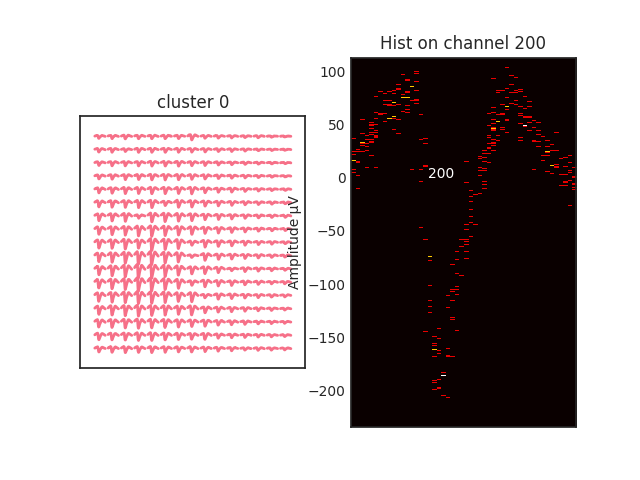

In [7]:
tdc.summary_catalogue_clusters(dataio=dataio, chan_grp=0, label=0)

## construct catalogue

In [8]:
cc.make_catalogue_for_peeler()

make_catalogue 6.2275991480019


## apply peeler

This is the real spike sorting: find spike that correcpond to catalogue templates.


In [4]:
initial_catalogue = dataio.load_catalogue(chan_grp=0)
peeler = Peeler(dataio)
peeler.change_params(catalogue=initial_catalogue,
            use_sparse_template=True,
            sparse_threshold_mad=1.5,
            use_opencl_with_sparse=True,

             cl_platform_index=1,
            cl_device_index=0)
peeler.run(duration=300.,
            progressbar=True)

average sparseness for templates 0.972549019608


100%|██████████| 5859/5859 [11:22<00:00,  8.59it/s]


## final inspection of cells

<IPython.core.display.Javascript object>


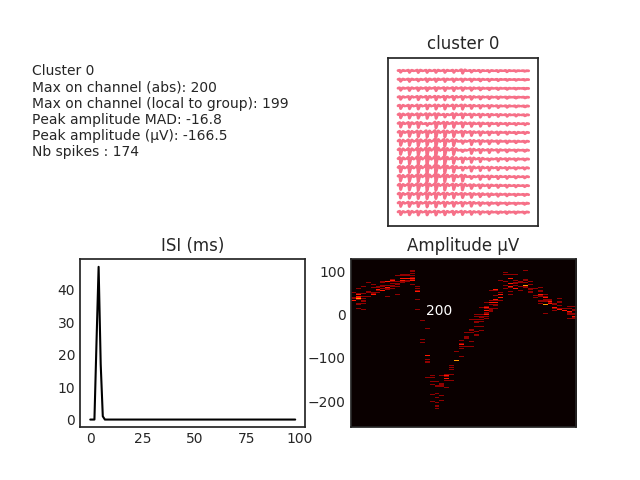

[<Figure size 640x480 with 3 Axes>]

In [9]:
tdc.summary_after_peeler_clusters(dataio, chan_grp=0,  label=0, neighborhood_radius=None, show_channels=False)

<IPython.core.display.Javascript object>


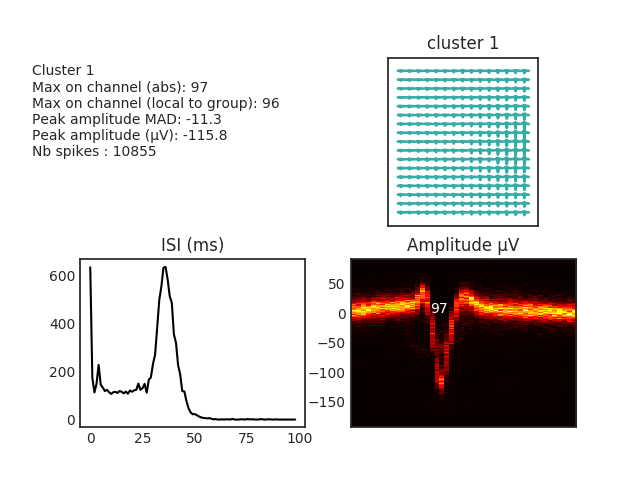

[<Figure size 640x480 with 3 Axes>]

In [10]:
tdc.summary_after_peeler_clusters(dataio, chan_grp=0,  label=1, neighborhood_radius=None, show_channels=False)